# Gaussian fit of the spots and training a ML algorithm to detect them automatically.

Before I can train a ML algorithm to detect the spots automatically, I will extract the spot locations through Gaussian fitting.

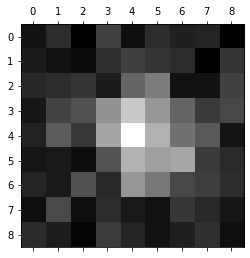

In [260]:
test = sliced[44,:,:] #the original spot
plt.matshow(test,cmap='gray')
plt.show()

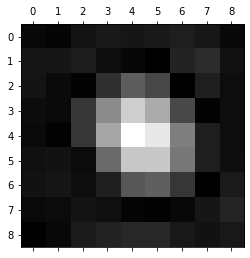

In [261]:
test = sliced1[44,:,:] #the spot without the noise looks so much nicer for this very noisy spot!
plt.matshow(test,cmap='gray')
plt.show()

In [262]:
def twoD_Gaussian(mesh, amplitude, x0, y0, sigma_x, sigma_y, offset): #defining a function for 2D Gaussian fit.
    mesh = (x, y)
    g = offset + amplitude*np.exp(-((x-x0)**2)/(2*sigma_x**2)-((y-y0)**2)/(2*sigma_y**2))
    
    return g.ravel()

In [263]:
# Create x and y indices for the fit.
x = np.linspace(0, 8, 9)
y = np.linspace(0, 8, 9)
x,y = np.meshgrid(x, y)
initial_guess = (500,4,4,1,1,800)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x,y), test.ravel(), p0 = initial_guess)



Here is a fit of a spot to the gaussian function. The fit looks good!

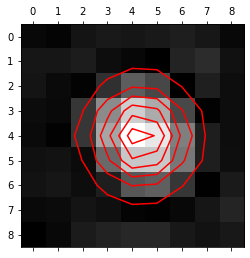

In [264]:
data_fitted = twoD_Gaussian((x, y),*popt)

plt.matshow(test, cmap=plt.cm.gray)
plt.contour(x, y, data_fitted.reshape(9, 9), 6, colors='r')
plt.show()

There are 294 spots detected in total in every frame. Note that, a protein might unbind or its signal may become weak compared to the treshold at certain frames, hence it may not be detected, but for now this is not a problem and I will account for this when I track a single molecule for 100 frames by making sure that a fit is realized for each and every frame.

In [244]:
spots.shape

(294, 3)

I am gathering each and every spot into a dataframe to use it in my ML algorithm.

In [265]:
#spots_trajectory = np.empty(shape=[0,2],dtype=np.int)
#spots_trajectory = np.append(1,spots_first_frame[0])

fitted_spots = np.empty(shape=[0,9])
    
for spot in range (spots.shape[0]):
    test1 = sliced1[spot,:,:]
    try:
        popt, pconv = opt.curve_fit(twoD_Gaussian,(x,y),test1.ravel(),p0=initial_guess)    
    except RuntimeError: #put an exception in case the gaussian fit fails.
        popt = np.array([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
    fit_param = np.resize(np.hstack([spots[spot],popt]),(1,9))
    fitted_spots = np.append(fitted_spots,fit_param,axis=0)

In [266]:
fit_info = pd.DataFrame(fitted_spots,columns=['Frame','xstart','ystart','Amplitude','xc','yc','sigma_x','sigma_y','offset'])

In [267]:
fit_info.head() #the dataframe consists of features for the spot fits.

,Frame,xstart,ystart,Amplitude,xc,yc,sigma_x,sigma_y,offset
0,0.0,140.0,35.0,168.341109,3.595833,4.007595,1.074264,1.257039,14.656508
1,0.0,79.0,36.0,117.455004,4.234112,3.936127,1.086235,1.169991,10.402490
2,0.0,77.0,29.0,96.267280,3.785493,4.181627,1.044520,1.133399,9.629731
3,0.0,63.0,80.0,80.647662,3.642418,3.736066,1.253986,1.134634,8.437299
4,0.0,60.0,34.0,90.355409,4.072362,4.203424,0.997636,1.119517,12.075083


In [268]:
train_data = sliced1 #my target variable is only x and y position so for now I am dropping the other features.
train_labels = fit_info.drop(columns = ['Frame','xstart','ystart','Amplitude','sigma_x','sigma_y','offset'])



Reshaping the train_data (9 by 9 array containing the light intensity) to feed into a regression model.

In [269]:
train_data = train_data.reshape(train_data.shape[0], 81) #reshape the input data


Scaling the data (intesities) because the bright pixels can be an order of magnitude brighter than the dark pixels, just to make sure that the algorithm has an easier time to find the center.

In [270]:
from sklearn.preprocessing import scale

for i in range(train_data.shape[0]):
    train_data[i] = (train_data[i] - np.mean(train_data[i])) / np.std(train_data[i])

Here I am splitting the data into train and test data sets to feed into a neural network. As the neural networks are preferred way to handle image classification, I first wanted to give it a try rather than other regression methods.

In [271]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=0)



I have tried many different layers, including convolutional layers to detect the spot centers but neither RNNs nor CNNs are very precise at detecting the image center. Deep learning is more useful in extracting features from an image. For instance; a neural network can easily classify if an image contains a cat by extracting different features such as whether it has eyes, a tail, legs etc. but in this case it fails to perform well.

In [273]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.utils import to_categorical

model = Sequential()

model.add(Dense(1000,activation='relu'))
model.add(Dense(1000,activation='relu'))

model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))


model.add(Dense(2,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adadelta')
model.fit(X_train,y_train.values,epochs=100) #train the network for 100 epochs 


Epoch 1/100
582/582 [==============================] - 5s 8ms/step - loss: 7.7911
Epoch 2/100
582/582 [==============================] - 1s 2ms/step - loss: 0.0847
Epoch 3/100
582/582 [==============================] - 2s 3ms/step - loss: 0.1129
Epoch 4/100
582/582 [==============================] - 2s 3ms/step - loss: 0.1503
Epoch 5/100
582/582 [==============================] - 2s 3ms/step - loss: 0.3872
Epoch 6/100
582/582 [==============================] - 2s 3ms/step - loss: 0.5692
Epoch 7/100
582/582 [==============================] - 1s 2ms/step - loss: 0.7157
Epoch 8/100
582/582 [==============================] - 1s 2ms/step - loss: 0.7392
Epoch 9/100
582/582 [==============================] - 2s 3ms/step - loss: 0.7408
Epoch 10/100
582/582 [==============================] - 2s 3ms/step - loss: 0.7975
Epoch 11/100
582/582 [==============================] - 1s 3ms/step - loss: 0.8160
Epoch 12/100
582/582 [==============================] - 1s 2ms/step - loss: 0.7033
Epoch 13/100


In [274]:
preds = model.predict(X_test)

Even though the validation loss decreases substantially after many epochs, the difference between the predictions and test values are too high to track the spots precisely.

In [275]:
preds[:5]

array([[4.491459 , 4.3106465],
       [3.791407 , 4.430593 ],
       [4.163996 , 3.8172686],
       [4.3458176, 3.754958 ],
       [4.0550756, 3.8861332]], dtype=float32)

In [276]:
y_test[:5]

,xc,yc
320,4.325282,4.249362
471,3.717781,4.375173
235,4.026997,3.772222
419,4.170994,3.727241
8,3.862729,3.808197


I will try linear regression instead to detect the spot centers.

In [277]:
from sklearn.linear_model import LinearRegression,Ridge
model = LinearRegression()

model.fit(X_train,y_train.values)

y_pred = model.predict(X_test)
model.score(X_test,y_test.values)


/Users/enescaglar/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.989321781140593

In [280]:
y_pred[:5] #the predicted values look very good.

array([[4.3411239 , 4.25092112],
       [3.70031159, 4.3508522 ],
       [4.04131922, 3.75470275],
       [4.1742342 , 3.69435057],
       [3.85491497, 3.85497781]])

In [279]:
y_test[:5]

,xc,yc
320,4.325282,4.249362
471,3.717781,4.375173
235,4.026997,3.772222
419,4.170994,3.727241
8,3.862729,3.808197


I also would like to perform Ridge Regression to prevent overfitting of the data, Ridge regression adds a penalty term to loss function which is proportional to the addition of the squares of the coefficients compared to OLS. The improvement is small as expected (it would be more useful if there were many different features). I will continue with the Ridge Regression.

In [281]:
ridge = Ridge()

ridge.fit(X_train,y_train.values)

y_pred = ridge.predict(X_test)
ridge.score(X_test,y_test.values)


/Users/enescaglar/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9894897864754152

Now that I can detect the center of my spot using Ridge Regression very accurately, I will apply this to find the trajectory of a spot during the entire movie. This will enable me to analyze the trajectory later and do a step size fit for the protein's movement.<br><br>
